In [2]:
!pip install pytorch_tabnet

  Using cached pytorch_tabnet-4.0-py3-none-any.whl (41 kB)


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor

In [134]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 데이터 로드
data = pd.read_csv('\\Users\\ineeji\\Desktop\\새 폴더\\Ineeji\\datas\\데이터합본_파생변수 제거.csv')
data['year'] = data['Unnamed: 0'].apply(lambda x : x.split()[0].split('-')[0])
data['month'] = data['Unnamed: 0'].apply(lambda x : x.split()[0].split('-')[1])
data['date'] = data['Unnamed: 0'].apply(lambda x : x.split()[0].split('-')[2])
data['hour'] = data['Unnamed: 0'].apply(lambda x : x.split()[1].split(' ')[0].split(':')[0])

data['year'] = data['year'].astype('int')
data['month'] = data['month'].astype('int')
data['date'] = data['date'].astype('int')
data['hour'] = data['hour'].astype('int')

lower_out = data['DSL D-95'].mean() - data['DSL D-95'].std()*3
upper_out = data['DSL D-95'].mean() + data['DSL D-95'].std()*3
data = data[(data['DSL D-95'] > lower_out) & (data['DSL D-95'] < upper_out)]

drop_list = data.corr()['DSL D-95'].map(abs).sort_values(ascending = False)[10:]
drop_list = pd.DataFrame(drop_list)
drop_list = drop_list.reset_index()
drop_list = drop_list['index']

train = data[(data['year'] == 2015) |(data['year'] == 2016) | (data['year'] == 2017) | (data['year'] == 2018)]
test = data[(data['year'] == 2019) |(data['year'] == 2020) | (data['year'] == 2021)]

train = train[train['hour'] == 7]
test = test[test['hour'] == 7]
test = test.reset_index(drop = True)
train_x = train.drop(['DSL D-95'],axis=1)
train_y = train['DSL D-95']
test_x = test.drop(['DSL D-95'],axis=1)
test_y = test['DSL D-95']

train_x.drop(drop_list,axis=1,inplace=True)
test_x.drop(drop_list,axis=1,inplace=True)
train_x.drop(['Unnamed: 0'],axis=1,inplace=True)
test_x.drop(['Unnamed: 0'],axis=1,inplace=True)


X_train, X_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size=0.2, random_state=9555)

C:\Users\ineeji\AppData\Local\Temp\ipykernel_5684\3633367802.py:19: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  drop_list = data.corr()['DSL D-95'].map(abs).sort_values(ascending = False)[10:]


In [139]:
# 모델 초기화
#tabnet = TabNetRegressor(n_d=8, n_a=8, n_steps=3, gamma=1.3, lambda_sparse=0, optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2), mask_type='entmax', device_name='auto')
#8.7

#tabnet = TabNetRegressor(n_d=16, n_a=16, n_steps=5, gamma=1.3, lambda_sparse=0, optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2), mask_type='entmax', device_name='auto')
#6.5

from pytorch_tabnet.tab_model import TabNetRegressor

model = TabNetRegressor(n_d=8, n_a=8, n_steps=2, gamma=1.3, lambda_sparse=0, optimizer_fn=torch.optim.Adam, optimizer_params=dict(lr=2e-2), mask_type='entmax', device_name=device)


In [141]:
# 학습
X_train_np = X_train.values
y_train_np = y_train.values
X_valid_np = X_valid.values
y_valid_np = y_valid.values
y_train_np = y_train_np.reshape(-1, 1)
y_valid_np = y_valid_np.reshape(-1, 1)

X_train_np = torch.tensor(X_train_np).to(device)
y_train_np = torch.tensor(y_train_np).to(device)
X_valid_np = torch.tensor(X_valid_np).to(device)
y_valid_np = torch.tensor(y_valid_np).to(device)

#model.fit( X_train_np, y_train_np, eval_set=[(X_train_np, y_train_np), (X_valid_np, y_valid_np)], eval_name=['train', 'val'], max_epochs=1000, patience=100)

model.fit( X_train=X_train.to_numpy(), y_train=y_train.to_numpy().reshape(-1,1), eval_set=[(X_train.to_numpy(), y_train.to_numpy().reshape(-1,1)), (X_valid.to_numpy(), y_valid.to_numpy().reshape(-1,1))], eval_name=['train', 'val'], max_epochs=1000, patience=100)

epoch 0  | loss: 161723.26562| train_mse: 98310.99812| val_mse: 94706.67022|  0:00:00s
epoch 1  | loss: 161482.90625| train_mse: 108692.22284| val_mse: 108393.21753|  0:00:00s
epoch 2  | loss: 161215.8125| train_mse: 118709.45305| val_mse: 118581.3198|  0:00:00s
epoch 3  | loss: 161102.51562| train_mse: 126377.96147| val_mse: 126200.25621|  0:00:00s
epoch 4  | loss: 160925.21875| train_mse: 130009.10971| val_mse: 130817.44177|  0:00:00s
epoch 5  | loss: 160650.32812| train_mse: 139155.00475| val_mse: 139837.43849|  0:00:00s
epoch 6  | loss: 160385.03125| train_mse: 143783.30878| val_mse: 144207.9576|  0:00:00s
epoch 7  | loss: 160161.40625| train_mse: 123859.8688| val_mse: 124199.32518|  0:00:00s
epoch 8  | loss: 159974.0625| train_mse: 125740.67529| val_mse: 124843.49439|  0:00:01s
epoch 9  | loss: 159509.26562| train_mse: 131108.58827| val_mse: 130165.9505|  0:00:01s
epoch 10 | loss: 159229.79688| train_mse: 133697.03387| val_mse: 133529.68257|  0:00:01s
epoch 11 | loss: 159031.40625

KeyboardInterrupt: 

In [130]:
abc = model.device
abc

device(type='cuda')

In [129]:
# 예측
test_x_np = test_x.values

y_pred = model.predict(test_x_np)
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(test_y,y_pred)
score

5.331071732802701

In [106]:
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(test_y,y_pred)
score

48.704076049526314

In [23]:
importance = tabnet.feature_importances_
importance

array([0.26842032, 0.03063448, 0.21317795, 0.28828022, 0.01125697,
       0.01811744, 0.08206685, 0.02498009, 0.06306569])

In [30]:
pip uninstall pytorch_tabnet

^C
Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install pytorch_tabnet

Note: you may need to restart the kernel to use updated packages.


AttributeError: module 'pytorch_tabnet.utils' has no attribute 'explain'

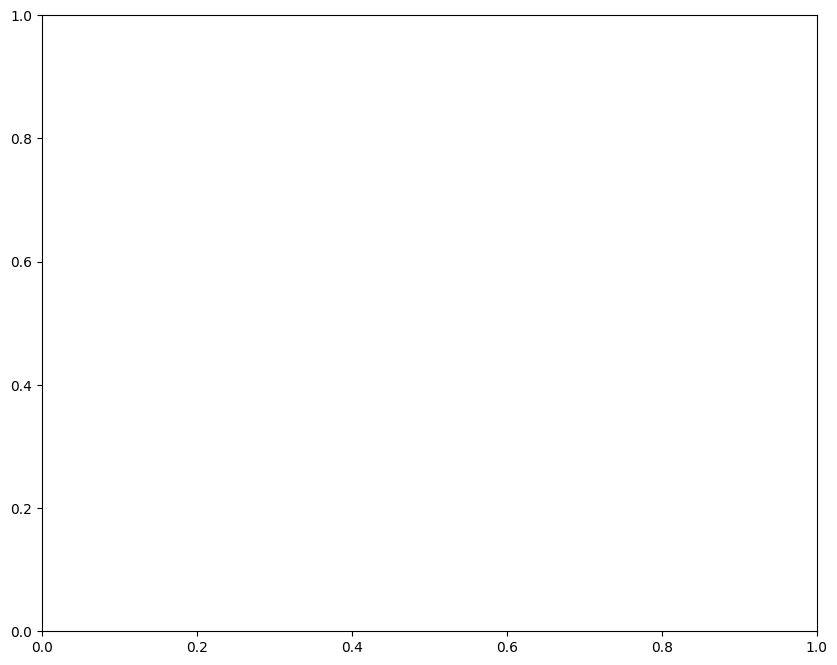

In [ ]:
import pytorch_tabnet.utils as utils
import matplotlib.pyplot as plt
feat_importances = tabnet.feature_importances_
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
utils.explain.plot_feature_importance(feat_importances, ax=axs)
plt.show()